# Imports

In [1]:
# import section
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import os
import cv2
import copy
import time

from skimage.feature import hog
from skimage.transform import resize

from google.colab import drive
from google.colab import files

!pip install scipy==1.6.2
!pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17

# Mount Drive

In [2]:
drive.mount("/content/drive", force_remount=True)
%ls
%cd '/content/drive/MyDrive/Colab Notebooks/V&P/assignment2_imageProcessing'
%ls

Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive/Colab Notebooks/V&P/assignment2_imageProcessing
CV_assignment_ImageProcessing_2.pdf  exercise_13_no.ipynb
es10/                                instance_exercise1-7.ipynb
es11/                                plot1.png
es12/                                plot2.png
es13/                                plot.png
exercise_10.ipynb                    sample_image_fast.jpg
exercise_11.ipynb                    sample_image_harris.jpg
exercise_12.ipynb                    try1-7Exercise.ipynb
exercise_13.ipynb                    working_env_harris.jpg


# Load data

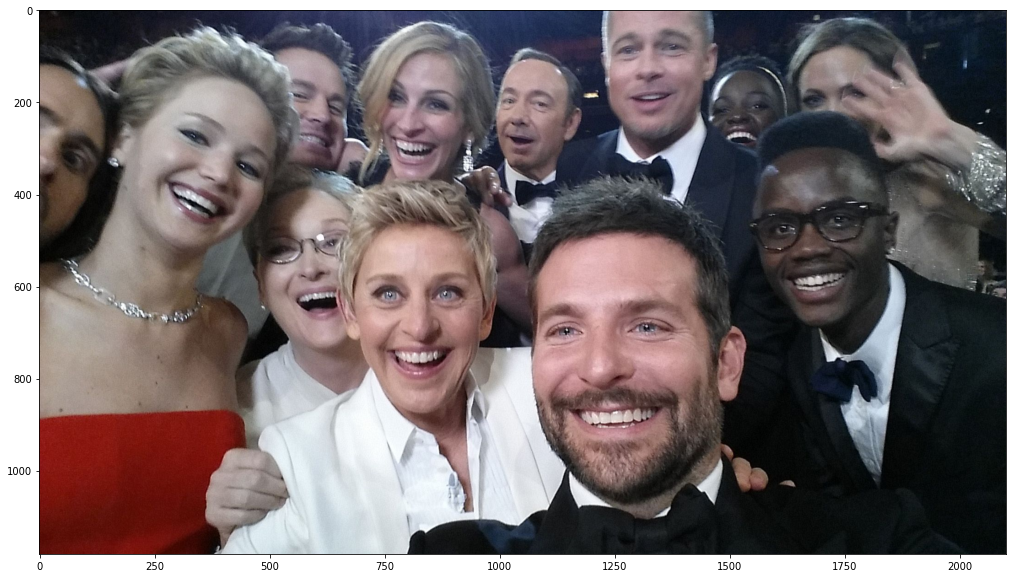

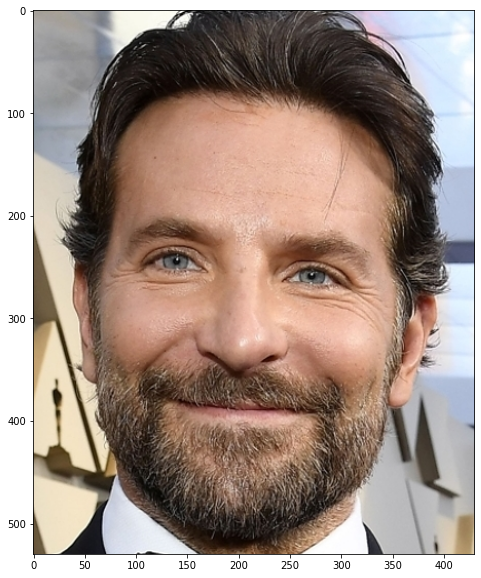

In [3]:
def readImage(path, show_it = True):
        img = cv2.imread(path)
        # img = cv2.resize(img,(800,600)) # 4:3
        img_converted = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        # img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        if show_it:
            fig,ax = plt.subplots(figsize=(25, 10))
            ax.imshow(img_converted, cmap=plt.cm.gray)
        return img_converted

def getFiles(path):
    images = []
    for file in os.listdir(path):
          images.append(readImage(path+'/' + file))
    return images

target = readImage("./es12/target image2.jpg")
template = readImage("./es12/template1.jpg",False)

template = template[50:580, 150:580]
fig,ax = plt.subplots(figsize=(25, 10))
ax.imshow(template, cmap=plt.cm.gray)

hte, wte, _ = template.shape

# First target image

## HOG descriptors

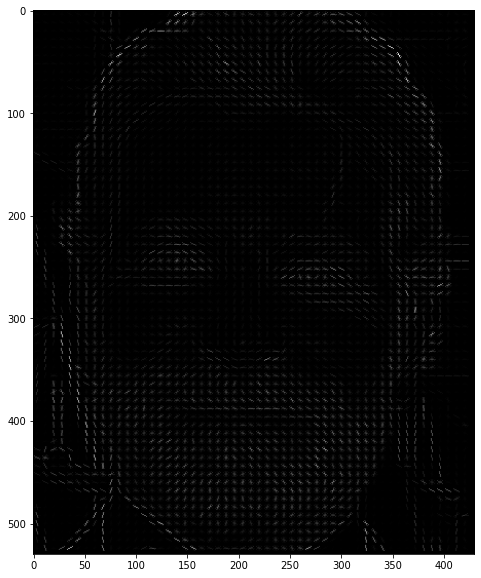

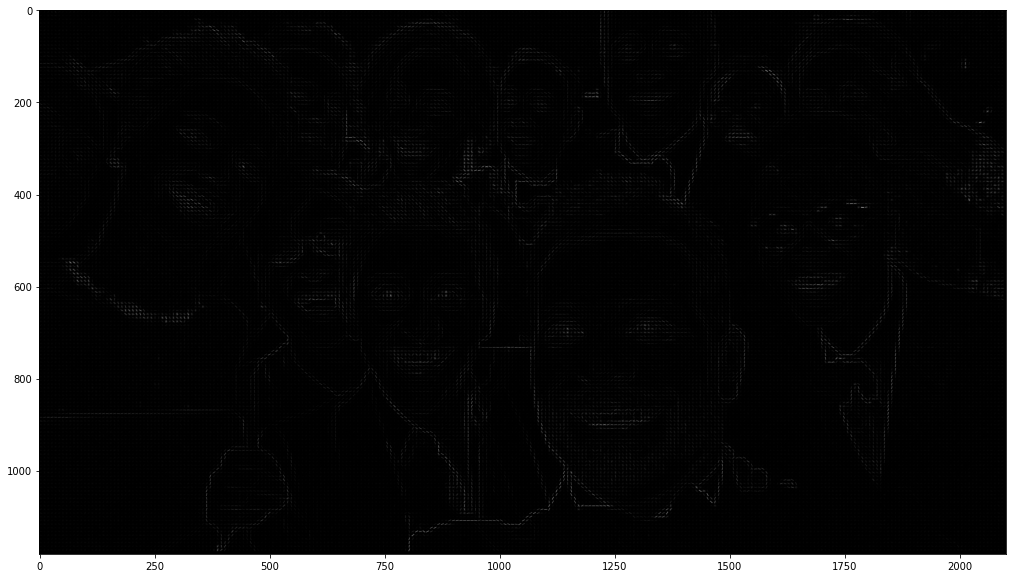

In [4]:
hog_descriptors_template, hog_image_template = hog(template, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
fig,ax = plt.subplots(figsize=(25, 10))
ax.imshow(hog_image_template, cmap=plt.cm.gray)

hog_descriptors_target, hog_image_target = hog(target, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
fig,ax = plt.subplots(figsize=(25, 10))
ax.imshow(hog_image_target, cmap=plt.cm.gray)

## NNC and extraction of the bounding boxes

number of bounding box: 135


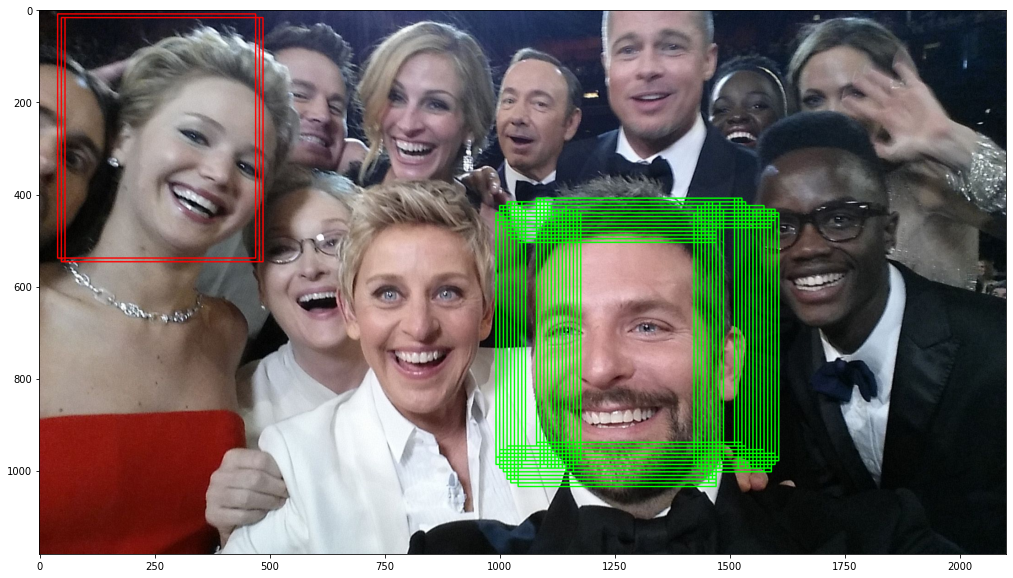

In [5]:
def check_correctness(actual_coords, correct_coords):
  correct_image = target.copy()[actual_coords[0]:actual_coords[0]+hte, actual_coords[1]:actual_coords[1]+ wte]
  actual_one = target.copy()[correct_coords[0]:correct_coords[0]+hte, correct_coords[1]:correct_coords[1]+wte]

  res = cv2.matchTemplate(correct_image,actual_one,cv2.TM_CCORR_NORMED)
  mean_ncc = np.mean(res)
  # print(mean_ncc)
  if mean_ncc > 0.8:  # at least 80% of corrispondence
    return True
  else:
    return False


# convert the images in a compatible format
hog_image_target = hog_image_target.astype(np.uint8)
hog_image_template = hog_image_template.astype(np.uint8)

# target = target.astype(np.uint8)
# template = template.astype(np.uint8)

# Compute the Normalized Cross Correlation
res = cv2.matchTemplate(hog_image_target,hog_image_template,cv2.TM_CCORR_NORMED) 
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# fix the threshold and take the corresponding coordinates 
# Threshold = 0.432
Threshold = 0.400
"""
Why this thresold? it seems to filter the most 3 correct ones coordinates in the image respect the
matching using the normalized cross correlation, which is very close to the maximum value obtained.
"""
coords_matches = np.argwhere(res>Threshold)
print("number of bounding box: {}".format(len(coords_matches)))
coords_matches = np.sort(coords_matches)
best_coords = (coords_matches[-1][0],coords_matches[-1][1])

# generate a new image to draw on
new_target = target.copy()

for i,coord in enumerate(coords_matches):
  # print(res[coord[0],coord[1]])

  # build the bunding box 
  top_left = (coord[1], coord[0])
  bottom_right = (top_left[0] + wte, top_left[1] + hte)

  is_correct = check_correctness((coord[0], coord[1]),best_coords)
  if is_correct:
    color = (0,255,0)
  else:
    color = (255,0,0)

  # draw the box
  cv2.rectangle(new_target,top_left, bottom_right, color = color, thickness = 2)

# plot the image generated 
fig,ax = plt.subplots(figsize=(25, 10))
ax.imshow(new_target, cmap=plt.cm.gray)

# Second target image

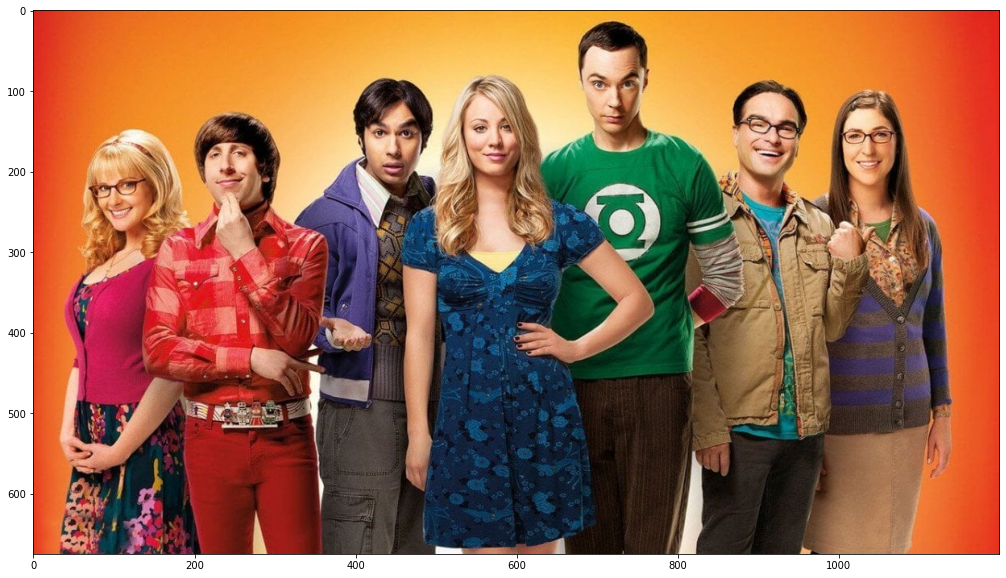

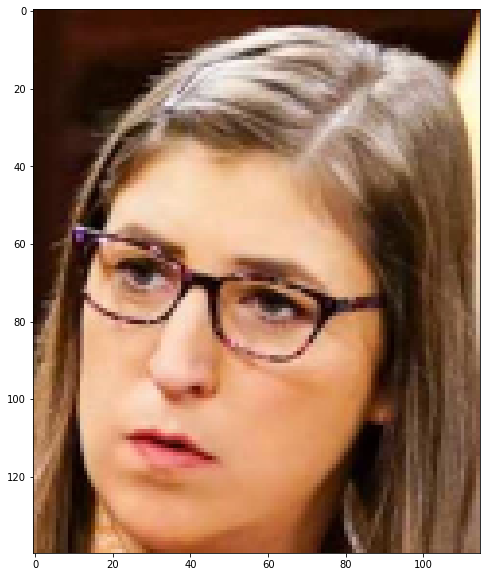

In [6]:
target = readImage("./es12/targetimage1.jpg")
template = readImage("./es12/template4.jpeg",False)


template = cv2.resize(template,(int(template.shape[1]/4),int(template.shape[0]/4)))
template = template[0:140, 25:140]
fig,ax = plt.subplots(figsize=(25, 10))
ax.imshow(template, cmap=plt.cm.gray)

hte, wte, _ = template.shape

## HOG descriptors

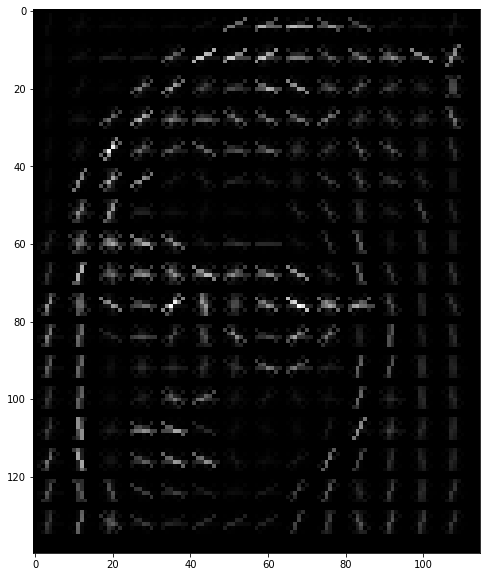

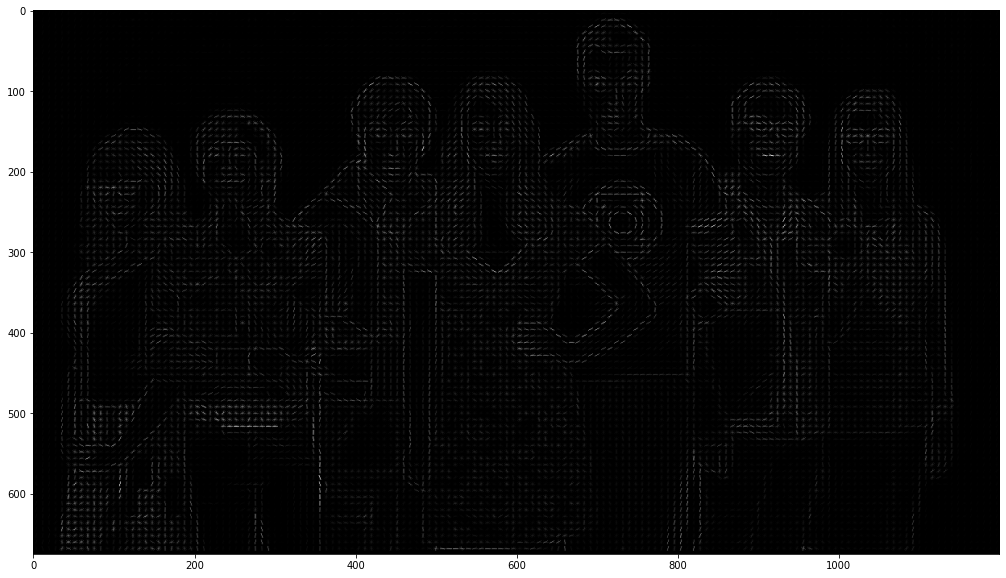

In [7]:
hog_descriptors_template, hog_image_template = hog(template, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
fig,ax = plt.subplots(figsize=(25, 10))
ax.imshow(hog_image_template, cmap=plt.cm.gray)

hog_descriptors_target, hog_image_target = hog(target, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
fig,ax = plt.subplots(figsize=(25, 10))
ax.imshow(hog_image_target, cmap=plt.cm.gray)

## NNC and extraction of the bounding boxes



number of bounding box: 4


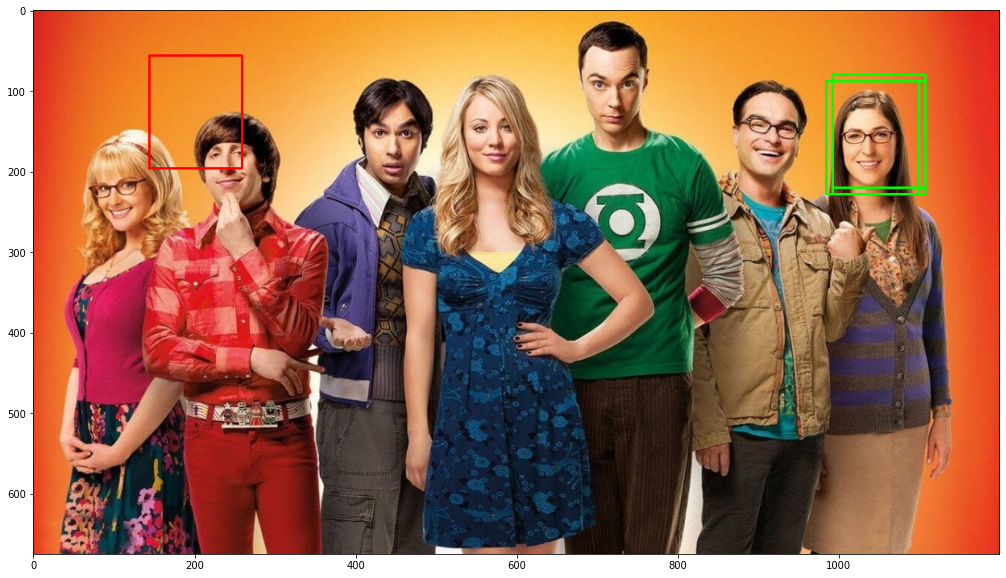

In [8]:
def check_correctness(actual_coords, correct_coords):
  correct_image = target.copy()[actual_coords[0]:actual_coords[0]+hte, actual_coords[1]:actual_coords[1]+ wte]
  actual_one = target.copy()[correct_coords[0]:correct_coords[0]+hte, correct_coords[1]:correct_coords[1]+wte]

  # hog_descriptors_template, correct_image = hog(correct_image, orientations=9, pixels_per_cell=(8, 8),
  #                     cells_per_block=(2, 2), visualize=True, multichannel=True)

  # hog_descriptors_target, actual_one = hog(actual_one, orientations=9, pixels_per_cell=(8, 8),
  #                     cells_per_block=(2, 2), visualize=True, multichannel=True)

  # correct_image = correct_image.astype(np.uint8)
  # actual_one = actual_one.astype(np.uint8)

  res = cv2.matchTemplate(correct_image,actual_one,cv2.TM_CCORR_NORMED)
  mean_ncc = np.mean(res)

  if mean_ncc > 0.9:
    return True
  else:
    return False


# convert the images in a compatible format
hog_image_target = hog_image_target.astype(np.uint8)
hog_image_template = hog_image_template.astype(np.uint8)

target = target.astype(np.uint8)
template = template.astype(np.uint8)

# Compute the Normalized Cross Correlation
res = cv2.matchTemplate(hog_image_target,hog_image_template,cv2.TM_CCORR_NORMED) 
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# fix the threshold and take the corresponding coordinates 

Threshold = 0.605

coords_matches = np.argwhere(res>=Threshold)
print("number of bounding box: {}".format(len(coords_matches)))
coords_matches = np.sort(coords_matches)
best_coords = (coords_matches[0][0],coords_matches[0][1])

# generate a new image to draw on
new_target = target.copy()

for i,coord in enumerate(coords_matches):
  # print(res[coord[0],coord[1]])
  
  # build the bunding box 
  top_left = (coord[1], coord[0])
  bottom_right = (top_left[0] + wte, top_left[1] + hte)

  is_correct = check_correctness((coord[0], coord[1]),best_coords)
  if is_correct:
    color = (0,255,0)
  else:
    color = (255,0,0)

  # draw the box
  cv2.rectangle(new_target,top_left, bottom_right, color = color, thickness = 2)

# plot the image generated 
fig,ax = plt.subplots(figsize=(25, 10))
ax.imshow(new_target, cmap=plt.cm.gray)